In [2]:

import matplotlib.pyplot as plt
import yaml
# with open('stats', 'r') as f:
#     data_full = yaml.load(f.read())

In [3]:
colors = [
'#c19277', #mpeg
'#62959c', #ours
'#9dad7f', #dds
'#d9dab0', #eaar
'#a98b98', #cloudseg
'#c1c0b9' # reducto
]

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse

def filter(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]

    if len(temp) == 0:
        print(keywords)
    return temp[-1]

def filters(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]

    if len(temp) == 0:
        print(keywords)
    return temp

def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['f1'] for i in data_list]

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = f'{filename}_time_{timestr}.pdf'
    fig.savefig(filename, bbox_inches='tight')

def add_data(ax, data, color):

    # print(data[1])
    cov = np.cov(data[0], data[1])
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_) / math.sqrt(len(data[0]))
    
    print(np.mean(data[1]))

    ell = Ellipse(xy=(np.mean(data[0]), np.mean(data[1])),
            width=lambda_[0]*2,
            height=lambda_[1]*2,
            angle=np.rad2deg(np.arccos(v[0,0])),
            alpha=0.9)
    ell.set_edgecolor(color)
    ell.set_facecolor(color)
    ax.add_artist(ell)
    #plt.scatter(data[0], data[1], c = color)
    ax.scatter([np.mean(data[0])], [np.mean(data[1])], marker = 'o', color = 'black', s=10,zorder=3)
    return np.mean(data[0]).item(), np.mean(data[1]).item()


In [6]:
# add ground truth bandwidth for normalization purpose
# for data in data_full:
#     data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# set default parameters
plt.style.use('default')
plt.rcParams['font.size']=30
plt.rc('font', family='sans-serif')
plt.rcParams["font.weight"] = "medium"
plt.rcParams['pdf.fonttype'] = 42

[1.0, 0.9747388362884521, 0.9691182374954224, 0.9627411365509033, 0.9555809497833252, 0.9006346464157104, 0.9159346222877502, 0.9180335402488708]
[0.31766410457891353] [0.7565427337374006]
[0.2150045807590539] [0.7893468652452741]
[0.43744428619509435] [0.8160415462085179]
[0.9883327497190795] [0.9034967337335859]
[0.08387245265644434] [0.6205188163689205]
[0.6713674561425752] [0.8044479829924447]


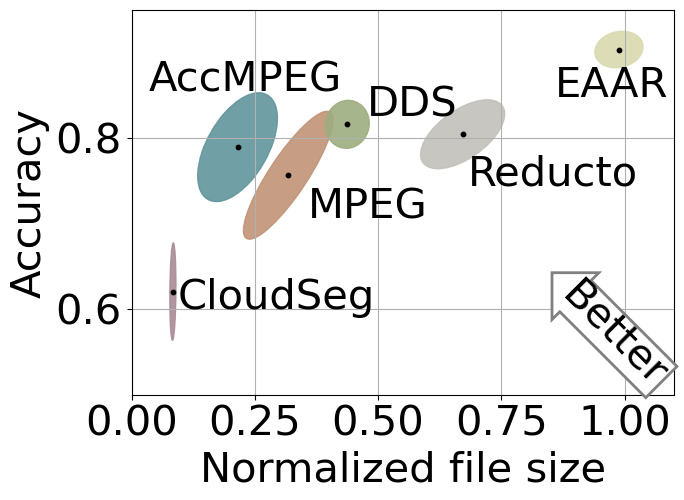

In [212]:
# plot dashcam for FPN
# plot multiple models

with open(f'stats_FPN', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'dashcam/dashcam_%d'
ids = [(i+1) for i in range(7)]

accs = [filter([fmt % i + '_', 'blackgen_', 'bound_0.5', 'conv_9']) for i in ids]
ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + '_qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    if len(batch) == 0:
        continue
    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()



x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.04, y - 0.05, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.18, y +0.065, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x + 0.04, y +0.01, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x - 0.13, y - 0.055, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x + 0.01, y - 0.02, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x + 0.01, y - 0.06, 'Reducto')
ax.set_xlim(0, 1.1)
ax.set_ylim(0.5, 0.95)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')


bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(1.1,0.5, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)



savefig('figs/detection_dashcam_FPN', fig)




8
{'application': 'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml', 'bw': 4169990, 'f1': 0.7011778950691223, 'fn': 2350, 'fp': 1347, 'ground_truth_name': 'visdrone/videos/vis_169_qp_30.mp4', 'pr': 0.8230633735656738, 're': 0.6717104911804199, 'tp': 7407, 'video_name': 'visdrone/videos/vis_169_blackgen_bound_0.2_qp_30_conv_13.mp4', 'gt_bw': 14573876}
8
{'application': 'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml', 'bw': 6174616, 'f1': 0.8165402412414551, 'fn': 3643, 'fp': 2781, 'ground_truth_name': 'visdrone/videos/vis_170_qp_30.mp4', 'pr': 0.8481098413467407, 're': 0.8032351136207581, 'tp': 14996, 'video_name': 'visdrone/videos/vis_170_blackgen_bound_0.2_qp_30_conv_13.mp4', 'gt_bw': 17433684}
8
{'application': 'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml', 'bw': 1159793, 'f1': 0.8354266881942749, 'fn': 401, 'fp': 529, 'ground_truth_name': 'visdrone/videos/vis_171_qp_30.mp4', 'pr': 0.8308531641960144, 're': 0.8584715723991394, 'tp': 2460, 'video_name': 'visdrone/videos/vis_171_blackgen_

Text(0, 0.5, 'Accuracy')

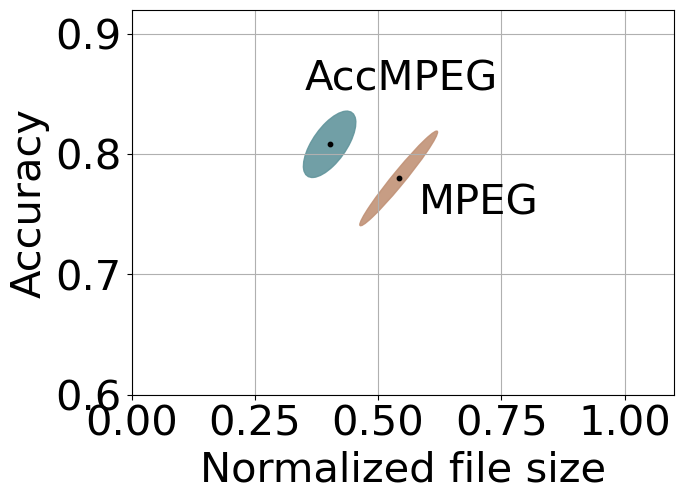

In [58]:

# # plot dashcam

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)

# # fmt = 'dashcam/dashcam_%d'
# # ids = [(i+1) for i in range(7)]

# accs = [filter([fmt % i + '_', 'bound_0.2', 'conv_13']) for i in ids]
# # ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
# # eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
# # cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
# # reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]

# mpegs = []
# for i, acc in zip(ids, accs):
#     batch = filters([(fmt % i) + '_qp_'])
#     print(len(batch))
#     print(acc)
#     if (i == 1):
#         print([i['f1'] for i in batch])

#     batch = [b for b in batch if b['f1'] < acc['f1']]
#     batch = sorted(batch, key=lambda x: -x['bw'])
#     mpegs.append(batch[0])
# # mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

# accs = transform(accs)
# mpegs = transform(mpegs)
# # ddss = transform(ddss)
# # eaars = transform(eaars)
# # cloudsegs = transform(cloudsegs)
# # reductos = transform(reductos)



# fig, ax = plt.subplots(figsize=(7, 5))
# ax.grid()

# x, y = add_data(ax, mpegs, colors[0])
# ax.text(x+0.04, y-0.03, 'MPEG')
# x, y = add_data(ax, accs, colors[1])
# ax.text(x-0.05, y+0.045, 'AccMPEG')
# # x, y = add_data(ax, ddss, colors[2])
# # ax.text(x-0.22, y, 'DDS')
# # x, y = add_data(ax, eaars, colors[3])
# # ax.text(x-0.25, y-0.03, 'EAAR')
# # x, y = add_data(ax, cloudsegs, colors[4])
# # ax.text(x+0.02, y+0.01, 'CloudSeg')
# # x, y = add_data(ax, reductos, colors[5])
# # ax.text(x-0.07, y-0.06, 'Reducto')
# ax.set_xlim(0, 1.1)
# ax.set_ylim(0.6, 0.92)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
# ax.set_xlabel('Normalized file size')
# ax.set_ylabel('Accuracy')

# # savefig('figs/detection_dashcam', fig)




0.7687479257583618
0.7980058073997498
0.6528869271278381
0.7999021649360657
0.4212186634540558
0.6127951383590698


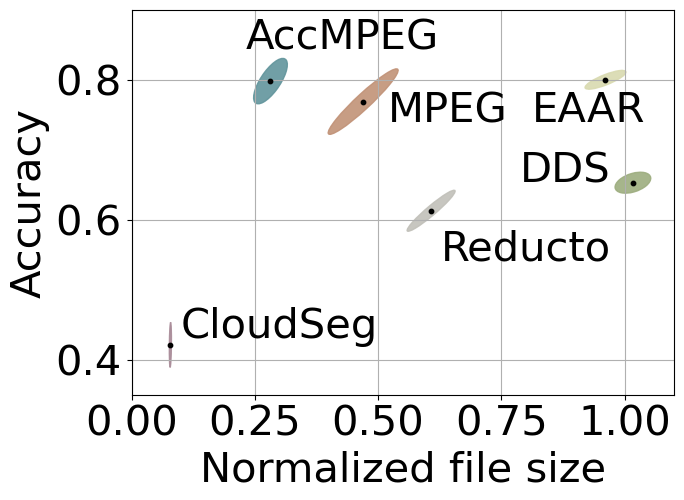

In [209]:

# # plot drone

# ids = [169, 170, 171, 172, 173]
# accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
# ddss = [filter([f'visdrone/videos/vis_{i}', 'dds']) for i in ids]
# eaars = [filter([f'visdrone/videos/vis_{i}', 'eaar']) for i in ids]
# cloudsegs = [filter([f'visdrone/videos/vis_{i}', 'cloudseg', '40']) for i in ids]
# reductos = [filter([f'visdrone/videos/vis_{i}', 'reducto', '28']) for i in ids]
# mpegs = []
# for i, acc in zip(ids, accs):
#     batch = filters([f'visdrone/videos/vis_{i}_qp'])

#     batch = [b for b in batch if b['f1'] < acc['f1']]
#     batch = sorted(batch, key=lambda x: -x['bw'])
#     mpegs.append(batch[0])

# accs = transform(accs)
# mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



# fig, ax = plt.subplots(figsize=(7, 5))
# ax.grid()

# x, y = add_data(ax, mpegs, colors[0])
# ax.text(x+0.05, y-0.03, 'MPEG')
# x, y = add_data(ax, accs, colors[1])
# ax.text(x-0.05, y+0.045, 'AccMPEG')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x-0.23, y, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x-0.15, y-0.06, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x+0.02, y+0.01, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x+0.02, y-0.07, 'Reducto')

# ax.set_xlim(0, 1.1)
# ax.set_ylim(0.35, 0.9)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
# ax.set_xlabel('Normalized file size')
# ax.set_ylabel('Accuracy')

# savefig('figs/detection_vis', fig)




0.31434229016304016
0.8256096839904785
0.8287256956100464
0.8286213278770447
0.7880367636680603
[0.4233771295152405] [0.6712861239910126]
[0.21272149836974957] [0.717067152261734]
[0.6687940559903517] [0.7774762153625489]
[1.082998609719524] [0.8691851019859314]
[0.07878285168912295] [0.4092743039131165]
[0.6074521296141242] [0.6225961089134217]


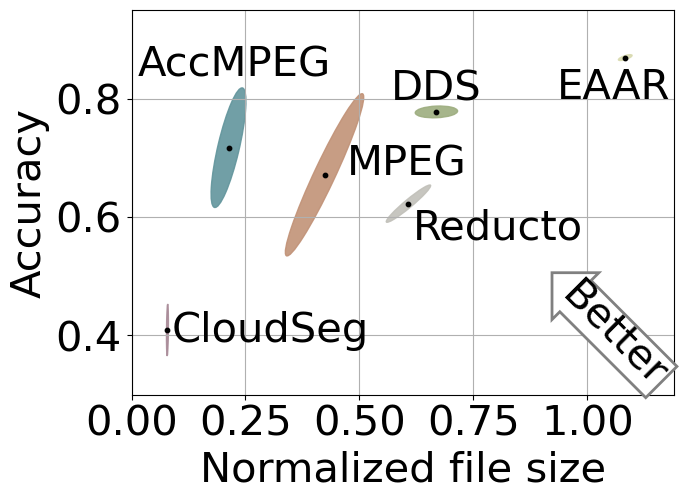

In [134]:
# plot drone for FPN


with open(f'stats_FPN', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'visdrone/videos/vis_%d_'
ids = range(169, 174)

accs = [filter([fmt % i, 'blackgen_','bound_0.5', 'conv_9']) for i in ids]
ddss = [filter([fmt % i, 'dds']) for i in ids]
eaars = [filter([fmt % i, 'eaar']) for i in ids]
cloudsegs = [filter([fmt % i, 'cloudseg', '40']) for i in ids]
reductos = [filter([fmt % i, 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + 'qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    print(acc['f1'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])

    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.05, y - 0.0, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.2, y +0.12, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x - 0.1, y +0.02, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x - 0.15, y - 0.07, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x + 0.01, y - 0.02, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x + 0.01, y - 0.06, 'Reducto')

l, r = 0, 1.19
b, u = 0.3, 0.95

ax.set_xlim(l,r)
ax.set_ylim(b,u)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_drone_FPN', fig)




0.8483760714530945
0.7380643725395203
0.7980058073997498


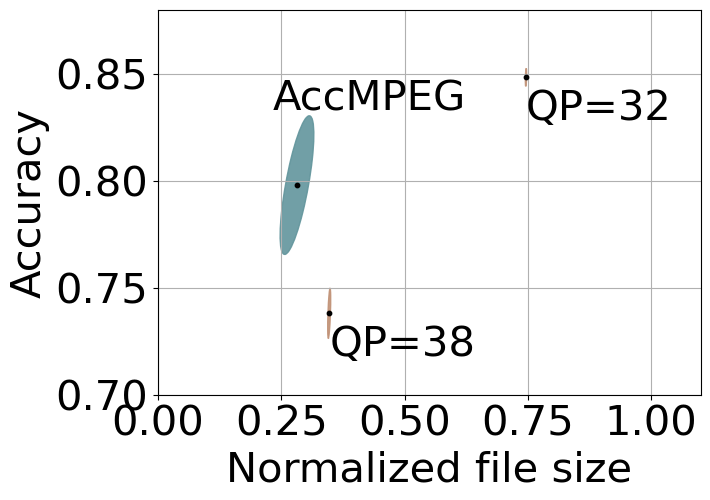

In [251]:

# plot dashcam for Fig18

ids = range(169, 174)
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
mpeg32 = [filter([f'visdrone/videos/vis_{i}_qp_32']) for i in ids]
mpeg42 = [filter([f'visdrone/videos/vis_{i}_qp_38']) for i in ids]

accs = transform(accs)
mpeg32 = transform(mpeg32)
mpeg42 = transform(mpeg42)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpeg32, colors[0])
ax.text(x, y-0.02, 'QP=32')
x, y = add_data(ax, mpeg42, colors[0])
ax.text(x, y-0.02, 'QP=38')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.035, 'AccMPEG')
ax.set_xlim(0, 1.1)
ax.set_ylim(0.7, 0.88)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_qp', fig)




[1.0, 0.7394072413444519, 0.7150043249130249, 0.6617176532745361, 0.5479476451873779, 0.526971161365509, 0.5495883822441101, 0.5225451588630676]
[0.32989079978403085] [0.6590235282977422]
[0.20009205220410994] [0.6771721030984607]
[0.3984107237699028] [0.7049246770995004]
[0.8602795344852632] [0.8333897164889744]
[0.08387245265644434] [0.5598094889095852]
[0.6713674561425752] [0.764575183391571]


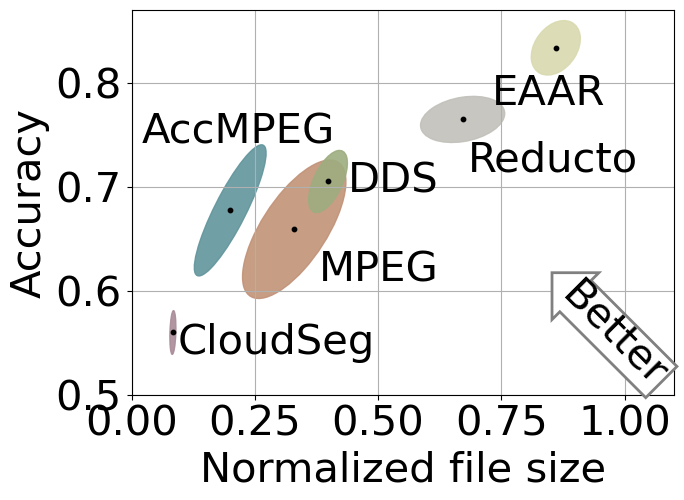

In [135]:
# plot multiple models

with open(f'stats_C4', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'dashcam/dashcam_%d'
ids = [(i+1) for i in range(7)]

accs = [filter([fmt % i + '_', 'bound_0.3', 'conv_9']) for i in ids]
ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + '_qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    if len(batch) == 0:
        continue
    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.05, y - 0.05, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.18, y +0.065, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x + 0.04, y -0.01, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x - 0.13, y - 0.055, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x + 0.01, y - 0.02, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x + 0.01, y - 0.05, 'Reducto')
ax.set_xlim(0, 1.1)
ax.set_ylim(0.5, 0.87)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(1.1,0.5, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_dashcam_C4', fig)




[1.0, 0.9075675010681152, 0.8780658841133118, 0.8573071956634521, 0.8107859492301941, 0.7743179798126221, 0.8332573175430298, 0.8274810910224915]
[0.399313566943141] [0.7521799036434719]
[0.275740232082189] [0.7889325278145927]
[0.3832163306024876] [0.745769202709198]
[0.7721683814754299] [0.845078102179936]
[0.08387245265644434] [0.6007537714072636]
[0.6713674561425752] [0.7870643224034991]


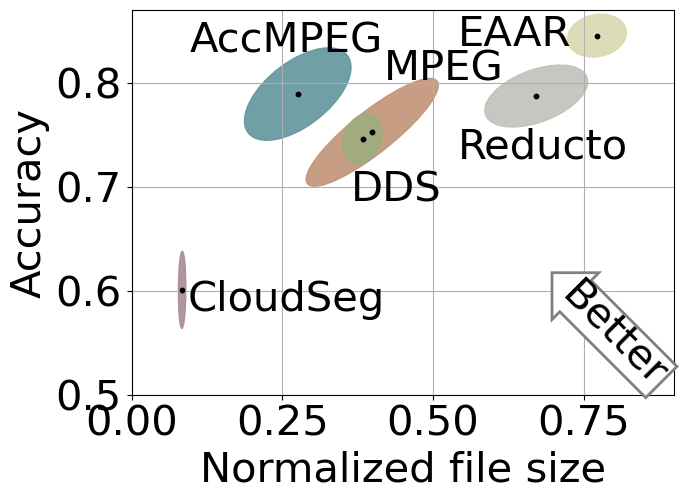

In [138]:
# plot multiple models

with open(f'stats_DC5', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'dashcam/dashcam_%d'
ids = [(i+1) for i in range(7)]

accs = [filter([fmt % i + '_', 'bound_0.2', 'conv_9']) for i in ids]
ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + '_qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    if len(batch) == 0:
        continue
    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.02, y + 0.05, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.18, y +0.04, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x-0.02 , y -0.06, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x - 0.23, y -0.01, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x + 0.01, y - 0.02, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x - 0.13, y - 0.06, 'Reducto')
ax.set_xlim(0, 0.9)
ax.set_ylim(0.5, 0.87)
ax.set_xticks([0, 0.25, 0.5, 0.75])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(0.9,0.5, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_dashcam_DC5', fig)




0.31434229016304016
0.8256096839904785
0.8287256956100464
0.8286213278770447
0.7880367636680603
[0.4233771295152405] [0.6712861239910126]
[0.21272149836974957] [0.717067152261734]


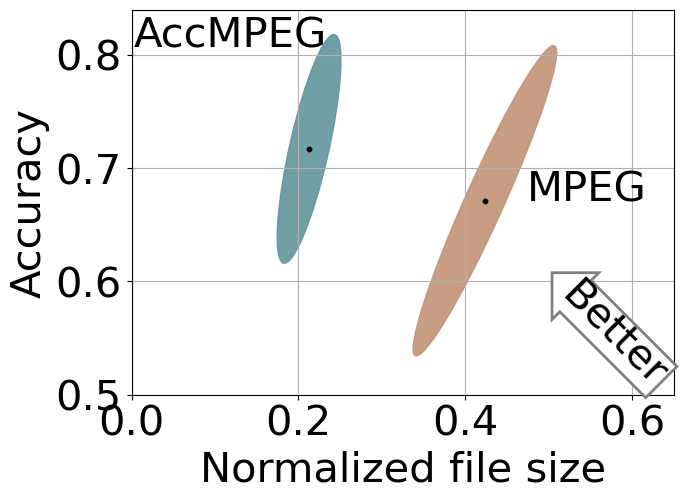

In [313]:
# Plot drone for different codec
# mp4:
# plot drone for FPN


with open(f'stats_FPN', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'visdrone/videos/vis_%d_'
ids = range(169, 174)

accs = [filter([fmt % i, 'blackgen_','bound_0.5', 'conv_9']) for i in ids]
# ddss = [filter([fmt % i, 'dds']) for i in ids]
# eaars = [filter([fmt % i, 'eaar']) for i in ids]
# cloudsegs = [filter([fmt % i, 'cloudseg', '40']) for i in ids]
# reductos = [filter([fmt % i, 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + 'qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    print(acc['f1'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])

    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.05, y - 0.0, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.21, y +0.09, 'AccMPEG')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x - 0.1, y +0.02, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.15, y - 0.07, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.01, y - 0.06, 'Reducto')

l, r = 0, 0.65
b, u = 0.5, 0.84

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_drone_FPN_mp4', fig)




0.41501981019973755
0.7352729439735413
0.8576062321662903
0.7820460200309753
0.7236846089363098
[0.4713403781607255] [0.6737716913223266]
[0.2740443238544002] [0.7027259230613708]


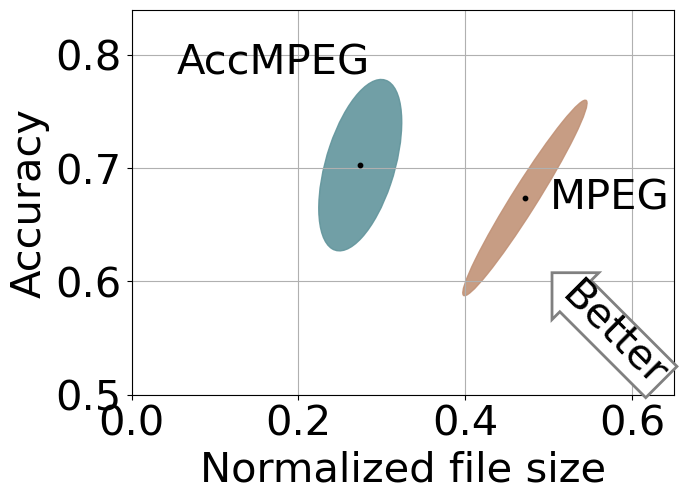

In [312]:
# Plot drone for different codec
# mp4:
# plot drone for FPN


with open(f'stats_FPN_hevc_new', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    if 'dashcam' in data['video_name']:
        continue
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'visdrone/videos/vis_%d_'
ids = range(169, 174)

accs = [filter([fmt % i, 'blackgen_','bound_0.5', 'conv_13']) for i in ids]
# ddss = [filter([fmt % i, 'dds']) for i in ids]
# eaars = [filter([fmt % i, 'eaar']) for i in ids]
# cloudsegs = [filter([fmt % i, 'cloudseg', '40']) for i in ids]
# reductos = [filter([fmt % i, 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + 'qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    print(acc['f1'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])

    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.03, y - 0.01, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.22, y +0.08, 'AccMPEG')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x - 0.1, y +0.02, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.15, y - 0.07, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.01, y - 0.06, 'Reducto')

l, r = 0, 0.65
b, u = 0.5, 0.84

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_drone_FPN_hevc', fig)




0.8579824209213257
0.8619641423225403


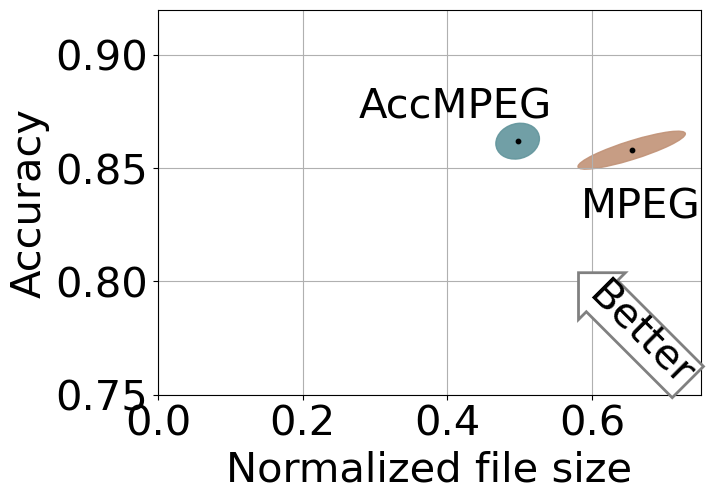

In [27]:
# Plot drone for different codec
# mp4:
# plot drone for FPN


with open(f'stats_FPN_webm_new', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    if 'dashcam' in data['video_name']:
        continue
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'visdrone/videos/vis_%d_'
ids = range(169, 174)


accs = [filter([fmt % 169, 'blackgen_', 'bound_0.25', 'conv_5'])] + [filter([fmt % i, 'blackgen_','bound_0.3_', 'conv_5']) for i in ids[1:]]
# ddss = [filter([fmt % i, 'dds']) for i in ids]
# eaars = [filter([fmt % i, 'eaar']) for i in ids]
# cloudsegs = [filter([fmt % i, 'cloudseg', '40']) for i in ids]
# reductos = [filter([fmt % i, 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + 'qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch_ = batch


    batch = [b for b in batch if b['f1'] < acc['f1']]

    if batch == []:
        batch = batch_
        batch = sorted(batch, key=lambda x: x['bw'])
        mpegs.append(batch[0])
    batch = sorted(batch, key=lambda x: -x['bw'])


    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x - 0.07 , y - 0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.22, y +0.01, 'AccMPEG')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x - 0.1, y +0.02, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.15, y - 0.07, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.01, y - 0.06, 'Reducto')

l, r = 0, 0.75
b, u = 0.75, 0.92

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

savefig('figs/detection_drone_FPN_webm', fig)




In [ ]:
# # plot multiple models

# with open(f'stats_FPN', 'r') as f:
#     data_full = yaml.load(f.read())
# # add ground truth bandwidth for normalization purpose
# for data in data_full:
#     data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# # fmt = 'visdrone/videos/vis_%d'
# # ids = range(169, 174)
# fmt = 'dashcam/dashcam_%d'
# ids = [(i+1) for i in range(7)]

# accs = [filter([fmt % i + '_', 'bound_0.5', 'conv_9']) for i in ids]
# ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
# eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
# cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
# reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


# mpegs = []
# for i, acc in zip(ids, accs):
#     batch = filters([(fmt % i) + '_qp_'])
#     # print(len(batch))
#     # print(acc)
#     if (i == 1):
#         print([i['f1'] for i in batch])

#     batch = [b for b in batch if b['f1'] < acc['f1']]
#     batch = sorted(batch, key=lambda x: -x['bw'])
#     mpegs.append(batch[0])
# # mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

# accs = transform(accs)
# mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



# fig, ax = plt.subplots(figsize=(7, 5))
# ax.grid()

# x, y = add_data(ax, mpegs, colors[0])
# ax.text(x + 0.03, y - 0.05, 'MPEG')
# x, y = add_data(ax, accs, colors[1])
# ax.text(x - 0.2, y +0.065, 'AccMPEG')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x + 0.03, y + 0.02, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.13, y - 0.06, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.04, y - 0.05, 'Reducto')
# ax.set_xlim(0, 1.1)
# ax.set_ylim(0.5, 0.93)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
# ax.set_xlabel('Normalized file size')
# ax.set_ylabel('Accuracy')

# savefig('figs/detection_dashcam_FPN', fig)




0.5861300468444824
0.6203420639038086
0.32340488880872725


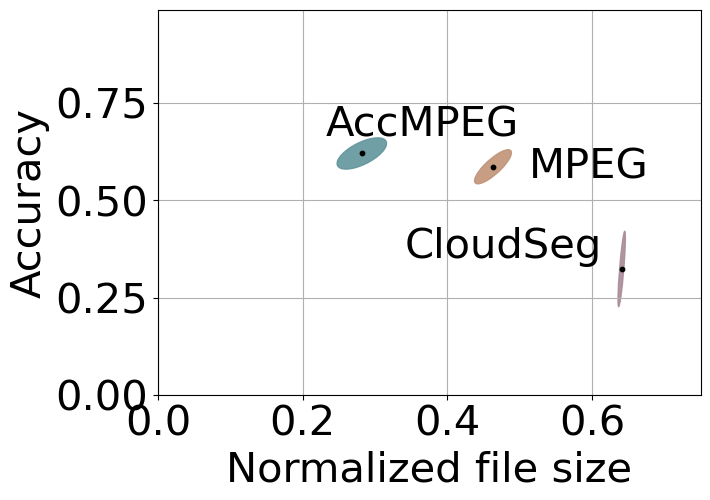

In [323]:

# plot segmentation drone


import matplotlib.pyplot as plt
import yaml
with open('frozen_stats/stats_segmentation', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['acc'] for i in data_list]

# plot drone

ids = [169, 170, 171, 172, 173]
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'visdrone/videos/vis_{i}_qp'])

    batch = [b for b in batch if b['acc'] < acc['acc']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])
cloudsegs = [filter([f'visdrone/videos/vis_{i}', 'cloudseg', 'qp_25']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
cloudsegs = transform(cloudsegs)


fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x+0.05, y-0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.045, 'AccMPEG')

ax.set_xlim(0, 0.75)
ax.set_ylim(0, 0.99)
#ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/segmentation_vis_fcn_resnet101', fig)

x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x-0.3, y+0.03, 'CloudSeg')

savefig('figs/segmentation_vis', fig)





0.3705990850925446
0.4324664771556854


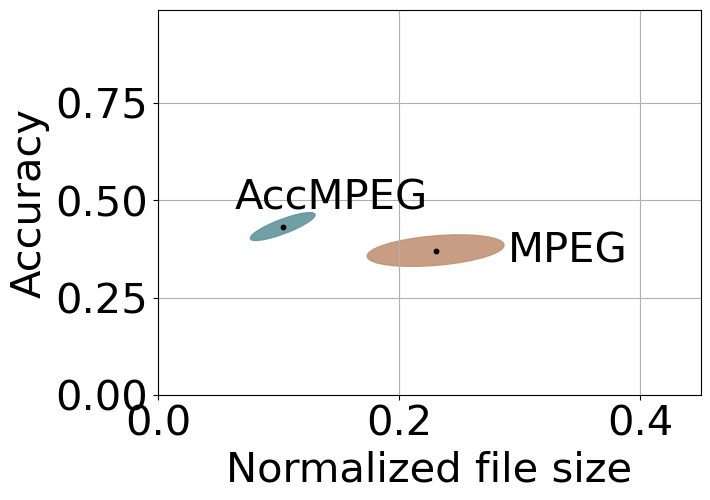

In [322]:

# plot segmentation drone


import matplotlib.pyplot as plt
import yaml
with open('frozen_stats/stats_segmentation', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['acc'] for i in data_list]

# plot drone

ids = [169, 170, 171, 172, 173]
accs = [filter([f'visdrone/videos/vis_{i}', 'resnet50', 'bound_0.65', 'conv_3']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'visdrone/videos/vis_{i}_qp'])

    batch = [b for b in batch if b['acc'] < acc['acc']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])
cloudsegs = [filter([f'visdrone/videos/vis_{i}', 'cloudseg', 'qp_25']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
cloudsegs = transform(cloudsegs)


fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x+0.06, y-0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.04, y+0.045, 'AccMPEG')
#x, y = add_data(ax, cloudsegs, colors[4])
#ax.text(x-0.3, y+0.03, 'CloudSeg')
ax.set_xlim(0, 0.45)
ax.set_ylim(0, 0.99)
#ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/segmentation_vis_fcn_resnet50', fig)





0.8219513495763143
0.8119104703267416


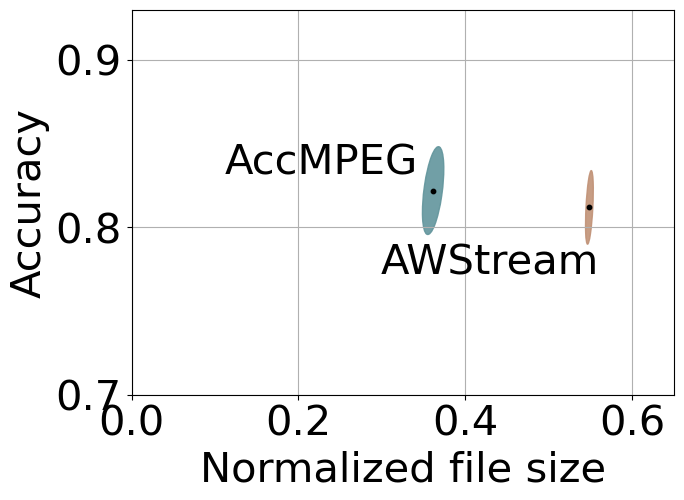

In [314]:
# plot keypoint detection
surf_1_bws = [11454999,7662046,6358532,5188001,4252464,3446187,2737375,2187879,1712798,1344957,1060612,839039]
surf_1_scores = [1.0,0.8206537961959839,0.7949020862579346,0.7647386193275452,0.7328758835792542,0.687320351600647,0.6179412007331848,0.5507842898368835,0.4981372356414795,0.3925490379333496,0.34196072816848755,0.26898691058158875]

surf_5_bws = [3076508,2036865,1672571,1339175,1081302,866046,684495,544472,428798,338723,270865,217871]
surf_5_scores = [1.0,0.7756468653678894,0.7387056350708008,0.7010586261749268,0.6622350215911865,0.6464704275131226,0.5597646236419678,0.5283529162406921,0.44023534655570984,0.32482361793518066,0.22129413485527039,0.1407058835029602]

surf_4_bws = [6676258,4384760,3594368,2891593,2374726,1938934,1581465,1303489,1063090,857588,690416,543422]
surf_4_scores = [0.8823530077934265,0.8634689450263977,0.8590311408042908,0.8403361439704895,0.8305163383483887,0.7788686752319336,0.7498818039894104,0.7100367546081543,0.6365781426429749,0.5164762139320374,0.4807855486869812,0.38353317975997925]

surf_2_bws = [27099065,18410326,15297979,12477185,10251647,8236259,6496109,5134393,3956311,3022542,2341396,1792340]
surf_2_scores = [0.7907191514968872,0.7731046676635742,0.7635949850082397,0.7356209754943848,0.7080393433570862,0.6700981259346008,0.6252614259719849,0.5833006501197815,0.5087581276893616,0.44816988706588745,0.38101303577423096,0.3005555272102356]

surf_8_bws = [35705679,23909865,19819264,16255630,13351802,10725248,8375030,6439313,4812860,3564893,2677431,2005120]
surf_8_scores = [1.0,0.871176540851593,0.850784420967102,0.8274511098861694,0.8078105449676514,0.7855228781700134,0.7451308369636536,0.7078431248664856,0.6465687155723572,0.5750654339790344,0.4961112141609192,0.3977777659893036]

surf_3_scores = [1.0,0.8764706254005432,0.8644445538520813,0.8387255668640137,0.8224837183952332,0.8006210923194885,0.761928141117096,0.7367319464683533,0.678071916103363,0.6273202896118164,0.5397385358810425,0.47728756070137024]
surf_3_bws = [46720286,31054066,24994302,19626937,15277791,11587635,8582071,6401940,4706101,3441949,2557787,1896363]

surf_4_047_bw = 2540871
surf_4_047_score = 0.8686619400978088

surf_2_047_bw = 10312504
surf_2_047_score = 0.746601402759552

surf_1_047_bw = 4127169
surf_1_047_score = 0.8021569848060608

surf_5_047_bw = 1158746
surf_5_047_score = 0.7502351999282837

surf_3_047_bw = 13980839
surf_3_047_score = 0.8849348425865173

surf_8_047_bw = 13239878
surf_8_047_score = 0.8791177272796631
import numpy as np

bws = np.mean(np.array([surf_1_bws,surf_2_bws,surf_4_bws,surf_5_bws,surf_3_bws,surf_8_bws]),axis=0)
scores = np.mean(np.array([surf_1_scores,surf_2_scores,surf_4_scores,surf_5_scores,surf_3_scores,surf_8_scores]),axis=0)

bw_047 = [surf_4_047_bw/surf_4_bws[0],surf_2_047_bw/surf_2_bws[0],surf_1_047_bw/surf_1_bws[0],surf_5_047_bw/surf_5_bws[0],surf_3_047_bw/surf_3_bws[0],surf_8_047_bw/surf_8_bws[0]]
score_047 = [surf_4_047_score,surf_2_047_score,surf_1_047_score,surf_5_047_score,surf_3_047_score,surf_8_047_score]

idx=2
bw_mpeg = [surf_4_bws[idx]/surf_4_bws[0],surf_2_bws[idx]/surf_2_bws[0],surf_1_bws[idx]/surf_1_bws[0],surf_5_bws[idx]/surf_5_bws[0],surf_3_bws[idx]/surf_3_bws[0],surf_8_bws[idx]/surf_8_bws[0]]
score_mpeg = [surf_4_scores[idx],surf_2_scores[idx],surf_1_scores[idx],surf_5_scores[idx],surf_3_scores[idx],surf_8_scores[idx]]

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, [bw_047, score_047], colors[1])
ax.text(x-0.25, y+0.01, 'AccMPEG')
x, y = add_data(ax, [bw_mpeg, score_mpeg], colors[0])
ax.text(x-0.25, y-0.04, 'AWStream')
ax.set_xlim(0, 0.65)
ax.set_ylim(0.7, 0.93)
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/keypoint_surf', fig)

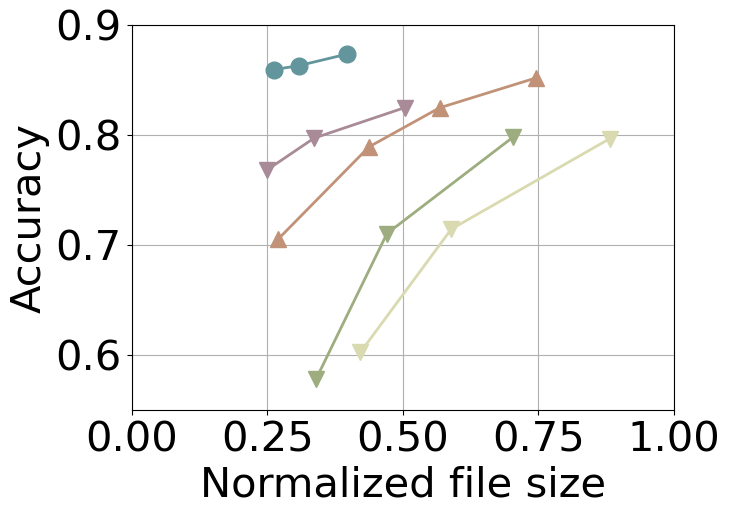

In [34]:
# plot measurement figure
with open('stats_FPN_measurement', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return np.mean([i['bw'] / i['gt_bw'] for i in data_list]), np.mean([i['f1'] for i in data_list])

# plot on all videos
v_list = ["visdrone/videos/vis_%d_" % i for i in range(169, 174)] 
# + [
#     "dashcam/dashcam_%d_" % i for i in range(1, 5)
# ]

gt_delta32 = transform([filter([v, 'gtbbox', 'delta_32']) for v in v_list])
gt_delta64 = transform([filter([v, 'gtbbox', 'delta_64']) for v in v_list])
gt_delta128 = transform([filter([v, 'gtbbox', 'delta_128']) for v in v_list])

qpvals = [32, 34, 36, 40]
qpdata = [transform([filter([f'{v}qp_{qp}']) for v in v_list]) for qp in qpvals]


qpvals = [44, 40, 36]
objdata = [transform([filter([v, 'blackgen_dual_obj', f'qp_{qp}']) for v in v_list]) for qp in qpvals]

highlow = [(30, 42), (34, 46), (38, 50)]
eaardata = [transform([filter([v, 'eaar3', f'qp_{low}_{high}']) for v in v_list]) for (high, low) in highlow]


highlow = [(40, 30), (44, 34), (48, 38)]
ddsdata = [transform([filter([v, 'dds2', f'qp_{low}_{high}']) for v in v_list]) for (low, high) in highlow]

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()
ax.set_xlim((0, 1))
ax.set_ylim(0.55, 0.9)
ax.plot([gt_delta32[0], gt_delta64[0], gt_delta128[0]], [gt_delta32[1], gt_delta64[1], gt_delta128[1]], c=colors[1], linewidth=2, markersize=12, marker='o', label='Ideal')

ax.plot([i[0] for i in qpdata], [i[1] for i in qpdata], c=colors[0], linewidth=2, markersize=12, marker='^', label='MPEG')
ax.plot([i[0] for i in objdata], [i[1] for i in objdata], c=colors[4], linewidth=2, markersize=12, marker='v', label='Object')
ax.plot([i[0] for i in eaardata], [i[1] for i in eaardata], c=colors[3], linewidth=2, markersize=12, marker='v', label='EAAR')
ax.plot([i[0] for i in ddsdata], [i[1] for i in ddsdata], c=colors[2], linewidth=2, markersize=12, marker='v', label='DDS')
# ax.set_yticks([0.85, 0.9])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')
savefig('figs/measurement_detection', fig)


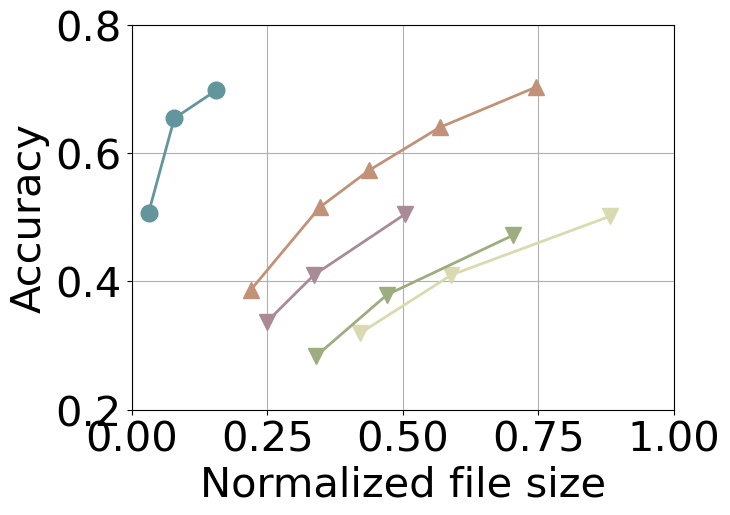

In [35]:
# plot measurement on segmentation
# plot measurement figure
with open('stats_fcn50_measurement', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return np.mean([i['bw'] / i['gt_bw'] for i in data_list]), np.mean([i['acc'] for i in data_list])

# plot drone

ids = [169, 170, 171, 172, 173]

gt_delta32 = transform([filter([f'visdrone/videos/vis_{i}', 'gt', 'conv_3']) for i in ids])
gt_delta64 = transform([filter([f'visdrone/videos/vis_{i}', 'gt', 'conv_11']) for i in ids])
gt_delta128 = transform([filter([f'visdrone/videos/vis_{i}', 'gt', 'conv_19']) for i in ids])

qpvals = [32, 34, 36, 38, 42]
qpdata = [transform([filter([f'visdrone/videos/vis_{i}_qp_{qp}']) for i in ids]) for qp in qpvals]

qpvals = [44, 40, 36]
objdata = [transform([filter([v, 'blackgen_dual_obj', f'qp_{qp}']) for v in v_list]) for qp in qpvals]


highlow = [(30, 42), (34, 46), (38, 50)]
eaardata = [transform([filter([v, 'eaar3', f'qp_{low}_{high}']) for v in v_list]) for (high, low) in highlow]


highlow = [(40, 30), (44, 34), (48, 38)]
ddsdata = [transform([filter([v, 'dds2', f'qp_{low}_{high}']) for v in v_list]) for (low, high) in highlow]


fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()
ax.set_xlim((0, 1))
ax.set_ylim(0.2, 0.8)
ax.plot([gt_delta32[0], gt_delta64[0], gt_delta128[0]], [gt_delta32[1], gt_delta64[1], gt_delta128[1]], c=colors[1], linewidth=2, markersize=12, marker='o', label='Ideal')

ax.plot([i[0] for i in qpdata], [i[1] for i in qpdata], c=colors[0], linewidth=2, markersize=12, marker='^', label='MPEG')
ax.plot([i[0] for i in objdata], [i[1] for i in objdata], c=colors[4], linewidth=2, markersize=12, marker='v', label='Object')
ax.plot([i[0] for i in eaardata], [i[1] for i in eaardata], c=colors[3], linewidth=2, markersize=12, marker='v', label='EAAR')
ax.plot([i[0] for i in ddsdata], [i[1] for i in ddsdata], c=colors[2], linewidth=2, markersize=12, marker='v', label='DDS')
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')
# ax.set_ylim(0, 0.73)
savefig('figs/measurement_segmentation', fig)


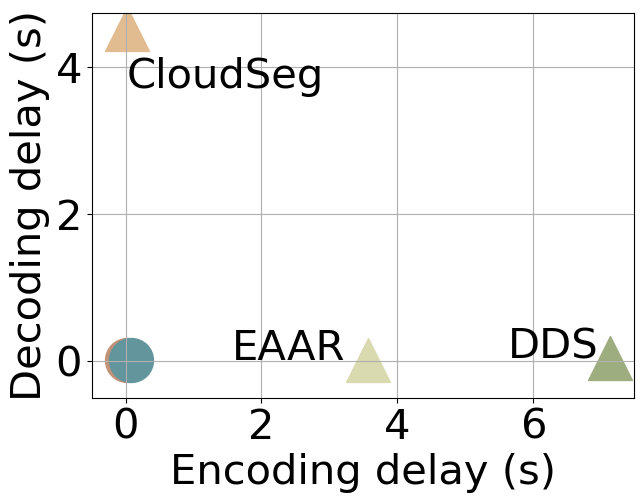

In [150]:
# plot ingestion delay
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14
cpu = np.mean(cpu) / 30
gpu = np.mean(gpu) / 30
inf_dnn = 3.55
inf_sr = 4.5

mpeg = [mp4, mp4]
acc = [mp4 + cpu, mp4]
dds = [mp4+mp4+inf_dnn+inf_dnn, mp4+mp4]
eaar = [mp4 + inf_dnn, mp4]
cloudseg = [mp4, mp4+inf_sr]
# reduc = [mp4, mp4]


fig, ax = plt.subplots(figsize=(7, 5))

def scat(name, c, deltax, deltay, text, marker):
    ax.scatter([name[0]], [name[1]], c=c, s=1000, marker=marker)
    ax.text(name[0]+deltax, name[1]+deltay, text)

scat(mpeg, colors[0], 0, 0, '', 'o')
scat(acc, colors[1], 0, 0, '', 'o')
scat(dds, colors[2], -1.5, 0, 'DDS', '^')
scat(eaar, colors[3], -2, 0, 'EAAR', '^')
scat(cloudseg, colors[4], 0, -0.8, 'CloudSeg', '^')
ax.set_xlim(left=-0.5)
ax.set_ylim(bottom=-0.5)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ax.set_xlabel('Encoding delay (s)')
ax.set_ylabel('Decoding delay (s)')
ax.grid()

savefig('figs/delay', fig)


0.054455289674635546


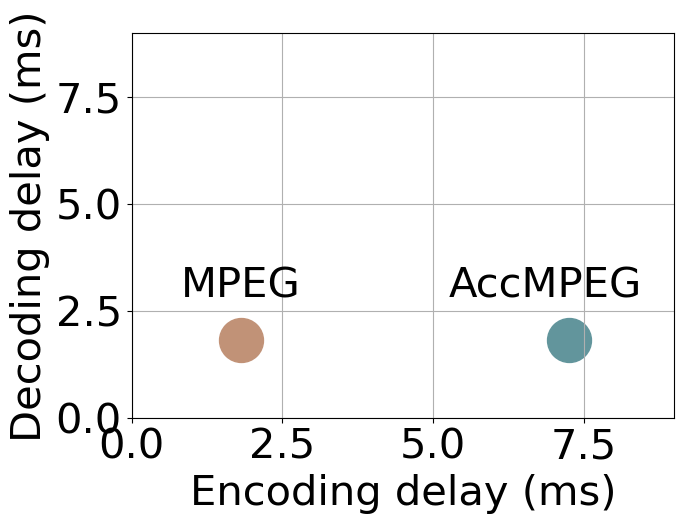

In [141]:

# plot ingestion delay
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14
cpu = np.mean(cpu) /30
gpu = np.mean(gpu)/30
inf_dnn = 3.55
inf_sr = 4.5

print(cpu)

mpeg = [mp4, mp4]
acc = [mp4 + cpu, mp4]
dds = [mp4+mp4+inf_dnn+inf_dnn, mp4+mp4]
eaar = [mp4 + inf_dnn, mp4]
cloudseg = [mp4, mp4+inf_sr]
# reduc = [mp4, mp4]


fig, ax = plt.subplots(figsize=(7, 5))

def scat(name, c, deltax, deltay, text, marker):
    ax.scatter([100*name[0]], [100*name[1]], c=c, s=1000, marker=marker)
    ax.text(100*name[0]+deltax, 100*name[1]+deltay, text)

scat(mpeg, colors[0], -1, 1, 'MPEG', 'o')
scat(acc, colors[1], -2, 1, 'AccMPEG', 'o')
ax.set_xlim((0, 9))
ax.set_ylim((0, 9))
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ax.set_xlabel('Encoding delay (ms)')
ax.set_ylabel('Decoding delay (ms)')
ax.grid()

savefig('figs/delay2', fig)


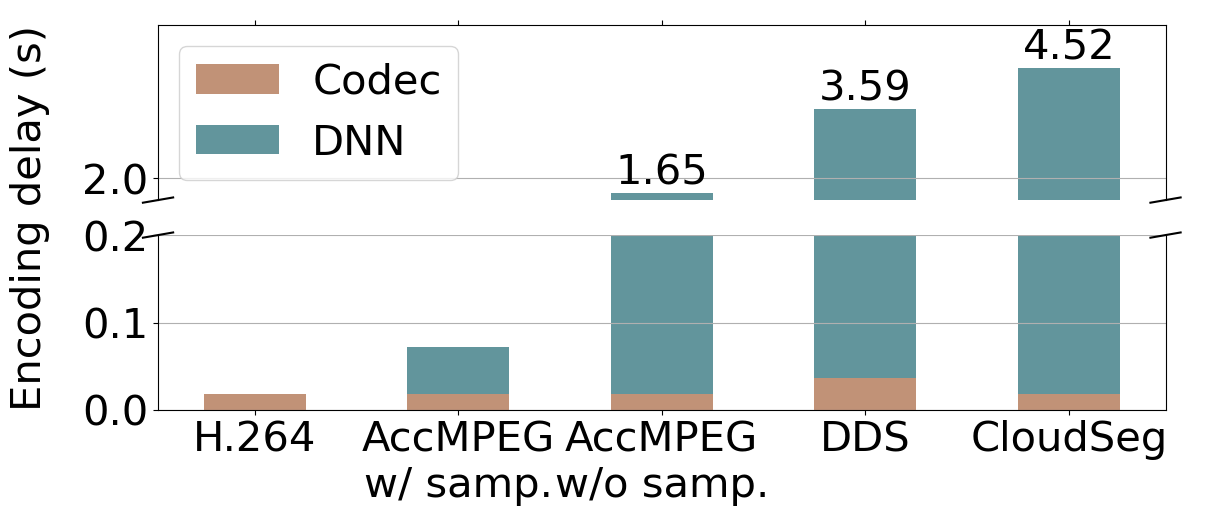

In [206]:
# plot ingestion delay
# Thanks to https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14
cpu = np.mean(cpu)
gpu = np.mean(gpu)
inf_dnn = 3.55
inf_dnn_fpn = 3.55
inf_dnn_C4 = 9.3
inf_dnn_DC5 = 4.5
inf_sr = 4.5

# h264, accmpeg, accmpeg, dds, cloudseg
encode = [mp4, mp4, mp4, 2 * mp4, mp4]
inference = [0, cpu/30, cpu, inf_dnn_fpn, inf_sr]
x_pos = [i*2+1 for i in range(len(encode))]
x_label = ['H.264', 'AccMPEG\nw/ samp.', 'AccMPEG\nw/o samp.', 'DDS', 'CloudSeg']

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13, 5))


ax1.bar(x_pos, encode, [1 for _ in range(len(x_pos))], [0 for _ in range(len(x_pos))], color=colors[0], label='Codec')
ax1.bar(x_pos, inference, [1 for _ in range(len(x_pos))], encode, color=colors[1], label='DNN')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_label)

ax2.bar(x_pos, encode, [1 for _ in range(len(x_pos))], [0 for _ in range(len(x_pos))],color=colors[0])
ax2.bar(x_pos, inference, [1 for _ in range(len(x_pos))], encode, color=colors[1])


ax2.set_ylim(0, 0.2)
ax1.set_ylim((1.5,5.5))
ax1.set_yticks([2])
ax1.set_yticklabels(['2.0'])
ax1.legend()

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False)
ax1.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax1.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal
# scat(mpeg, colors[0], 0, 0, '', 'o')
# scat(acc, colors[1], 0, 0, '', 'o')
# scat(dds, colors[2], -1.5, 0, 'DDS', '^')
# scat(eaar, colors[3], -2, 0, 'EAAR', '^')
# scat(cloudseg, colors[4], 0, -0.8, 'CloudSeg', '^')
# ax.set_xlim(left=-0.5)
# ax.set_ylim(bottom=-0.5)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
# ax.set_xlabel('Encoding delay (s)')
# ax1.grid()
ax2.grid(axis='y')
ax1.grid(axis='y')

for i in range(1, len(x_label)):
    if i == 1:
        continue
    ax1.text(i*2+1, encode[i]+inference[i], "%.2f" % (encode[i]+inference[i]), ha='center', va='bottom')

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Encoding delay (s)")
# plt.ylabel("common Y")

savefig('figs/encoding_delay', fig)


[0.4233771295152405] [0.6712861239910126]
[0.21272149836974957] [0.717067152261734]
[0.25864052244226915] [0.8390089273452759]


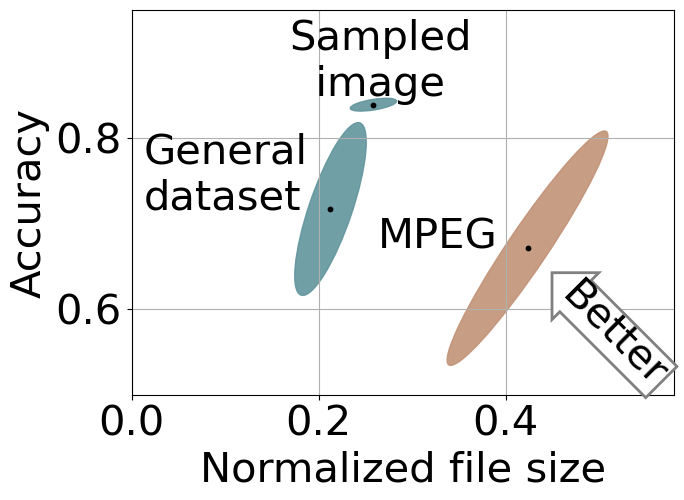

In [252]:
# plot dashcam for FPN
# between different training set.

with open(f'stats_FPN', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

fmt = 'visdrone/videos/vis_%d'
ids = range(169, 174)
# fmt = 'dashcam/dashcam_%d'
# ids = [(i+1) for i in range(7)]

accs = [filter([fmt % i + '_', 'blackgen_' 'bound_0.5', 'conv_9']) for i in ids]
acc2s = [filter([fmt % i + '_', 'blackgenvisdrone_' 'bound_0.8', 'conv_9']) for i in ids]
# ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
# eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
# cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
# reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + '_qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    if len(batch) == 0:
        continue
    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
acc2s = transform(acc2s)
mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()



x, y = add_data(ax, mpegs, colors[0])
ax.text(x - 0.16, y, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.2, y, 'General\ndataset')
x, y = add_data(ax, acc2s, colors[1])
ax.text(x - 0.09, y +0.01, 'Sampled\n  image')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x + 0.04, y +0.01, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.13, y - 0.055, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.01, y - 0.06, 'Reducto')
ax.set_xlim(0, 0.58)
ax.set_ylim(0.5, 0.95)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')


bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(0.58,0.5, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)



savefig('figs/detection_drone_FPN_trainingset', fig)




[1.0, 0.9747388362884521, 0.9691182374954224, 0.9627411365509033, 0.9555809497833252, 0.9006346464157104, 0.9159346222877502, 0.9180335402488708]
[0.31766410457891353] [0.7565427337374006]
[0.2150045807590539] [0.7893468652452741]
[0.04629724985383509] [0.45006743924958365]


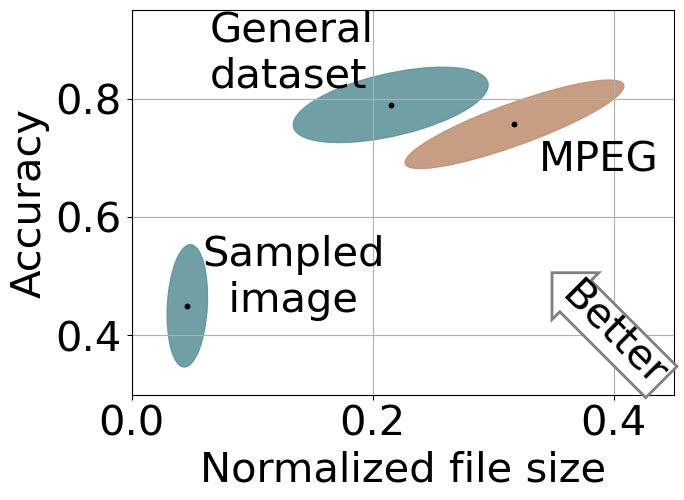

In [250]:
# plot dashcam for FPN
# between different training set.

with open(f'stats_FPN', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# fmt = 'visdrone/videos/vis_%d'
# ids = range(169, 174)
fmt = 'dashcam/dashcam_%d'
ids = [(i+1) for i in range(7)]

accs = [filter([fmt % i + '_', 'blackgen_' 'bound_0.5', 'conv_9']) for i in ids]
acc2s = [filter([fmt % i + '_', 'blackgenvisdrone_' 'bound_0.7', 'conv_9']) for i in ids]
# ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
# eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
# cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
# reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]


mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([(fmt % i) + '_qp_'])
    # print(len(batch))
    # print(acc)
    if (i == 1):
        print([i['f1'] for i in batch])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    if len(batch) == 0:
        continue
    mpegs.append(batch[0])
# mpegs = [filter([fmt%i + '_' + 'qp_40']) for i in ids]

accs = transform(accs)
acc2s = transform(acc2s)
mpegs = transform(mpegs)
# ddss = transform(ddss)
# eaars = transform(eaars)
# cloudsegs = transform(cloudsegs)
# reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()



x, y = add_data(ax, mpegs, colors[0])
ax.text(x + 0.02, y - 0.08, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x - 0.15, y + 0.03, 'General\ndataset')
x, y = add_data(ax, acc2s, colors[1])
ax.text(x + 0.012, y - 0.01, 'Sampled\n  image')
# x, y = add_data(ax, ddss, colors[2])
# ax.text(x + 0.04, y +0.01, 'DDS')
# x, y = add_data(ax, eaars, colors[3])
# ax.text(x - 0.13, y - 0.055, 'EAAR')
# x, y = add_data(ax, cloudsegs, colors[4])
# ax.text(x + 0.01, y - 0.02, 'CloudSeg')
# x, y = add_data(ax, reductos, colors[5])
# ax.text(x + 0.01, y - 0.06, 'Reducto')
ax.set_xlim(0, 0.45)
ax.set_ylim(0.3, 0.95)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')


bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(0.45,0.3, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)



savefig('figs/detection_dashcam_FPN_trainingset', fig)




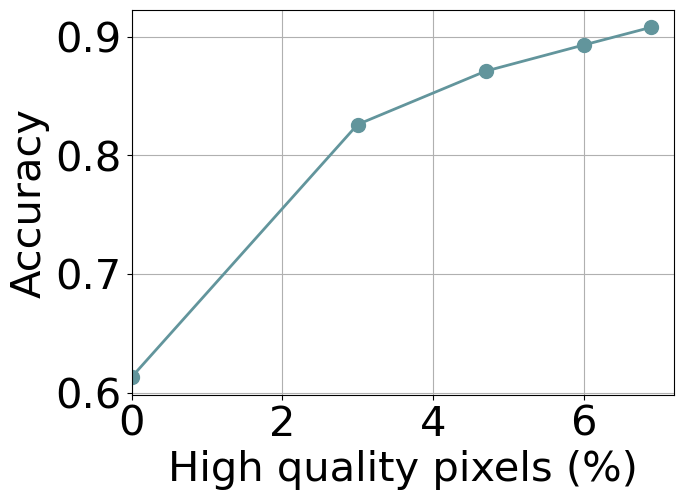

In [340]:

x = [0, 0.03, 0.047, 0.06, 0.069]
y = [0.613, 0.826, 0.871, 0.893, 0.908]

fig, ax = plt.subplots(figsize=(7, 5))


ax.plot([x_*100 for x_ in x], y, c=colors[1], markersize=10, marker='o', linewidth=2)

ax.set_xlim(0, 7.2)
ax.grid()
ax.set_xlabel('High quality pixels (%)')
ax.set_ylabel('Accuracy')
savefig('figs/hq_percentage', fig)


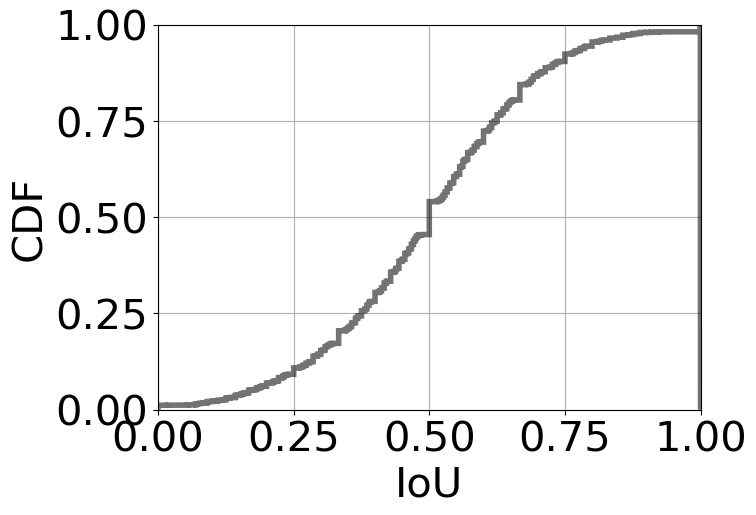

In [281]:
# cdf of IoU between obj and ideal

import re

x = re.compile('IoU: ([0-9.]+)')

with open('meas.log', 'r') as f:
    ious = [float(i) for i in x.findall(f.read())]

fig, ax = plt.subplots(figsize=(7, 5),)
ax.grid()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('IoU')
ax.set_ylabel('CDF')

ax.hist(ious, bins=5000, density=True, cumulative=True, label='CDF DATA', 
         histtype='step', alpha=0.55, lw=4, color='black')

savefig('figs/obj_ideal_iou_cdf', fig)

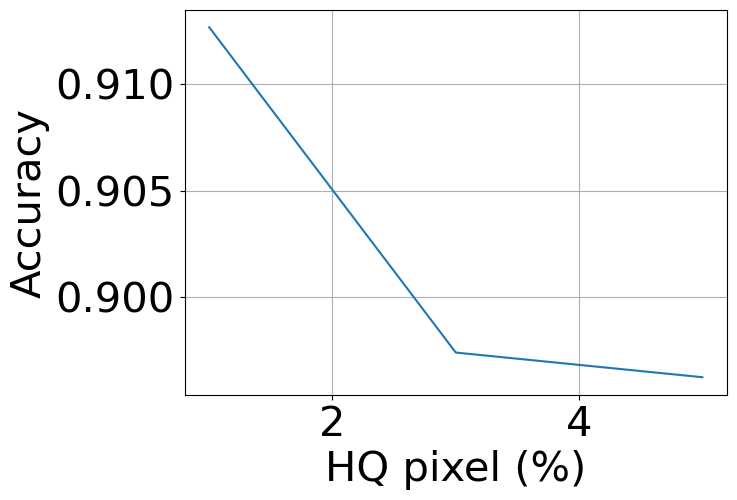

In [293]:
# cdf of IoU between obj and ideal

import re
import numpy as np

x = re.compile('f1: ([0-9.]+)\nPerc: ([0-9.]+)')

res = []

with open('meas.log', 'r') as f:
    for i in x.findall(f.read()):
        f1, perc = i
        f1, perc = float(f1), float(perc)
        res.append({'f1': f1, 'perc': perc})

def getval(val):

    ret = []
    val = val / 100

    for i in res:
        if val - 0.01 < i['perc'] < val + 0.01:
            ret = ret + [i['f1']]
    return np.mean(ret).item()

fig, ax = plt.subplots(figsize=(7, 5),)
ax.grid()
# ax.set_xlim(0, 8)
# ax.set_ylim(0, 1)
ax.set_xlabel('HQ pixel (%)')
ax.set_ylabel('Accuracy')

vals = [1,3,5]

ax.plot(vals, [getval(i) for i in vals])

# ax.hist(ious, bins=5000, density=True, cumulative=True, label='CDF DATA', 
#          histtype='step', alpha=0.55, lw=4, color='black')

# savefig('figs/obj_ideal_iou_cdf', fig)

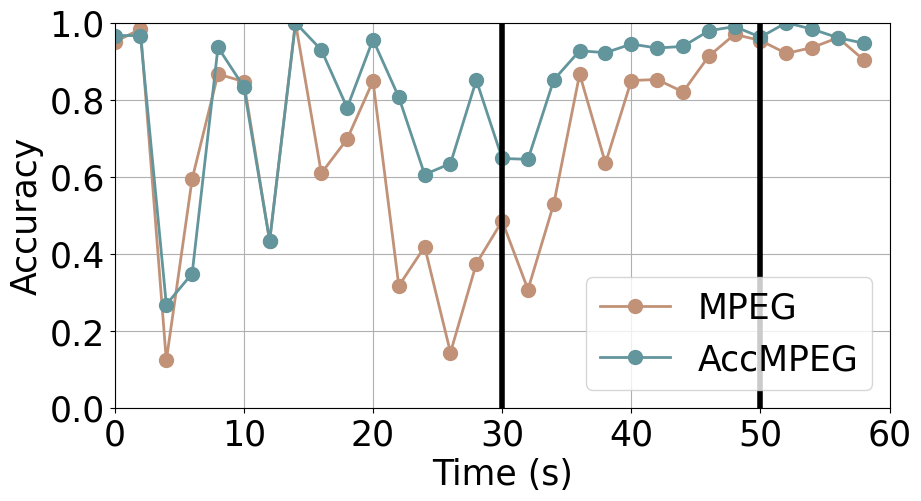

In [99]:

import matplotlib.pyplot as plt
import yaml
with open('stats_adapt_drive', 'r') as f:
    data_full = yaml.load(f.read())

plt.rcParams['font.size']=25

accmpeg = [filter(['adapt/drive_%d_blackgen_bound_0.3' % i]) for i in range(10, 40)]

mpeg = [filter(['adapt/drive_%d_qp_44' % i]) for i in range(10, 40)]

fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(range(0, 60, 2), [i['f1'] for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')

ax.plot(range(0, 60, 2), [i['f1'] for i in mpeg], c=colors[0], markersize=10, marker='o', linewidth=2, label='MPEG')

ax.plot(range(0, 60, 2), [i['f1'] for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')


ax.axvline(30, linewidth=4, c='black')
ax.axvline(50, linewidth=4, c='black')
ax.legend(loc=0)

ax.set_ylim(0, 1)
ax.set_xlim(0, 60)


ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')

savefig('figs/const_heat_acc', fig)

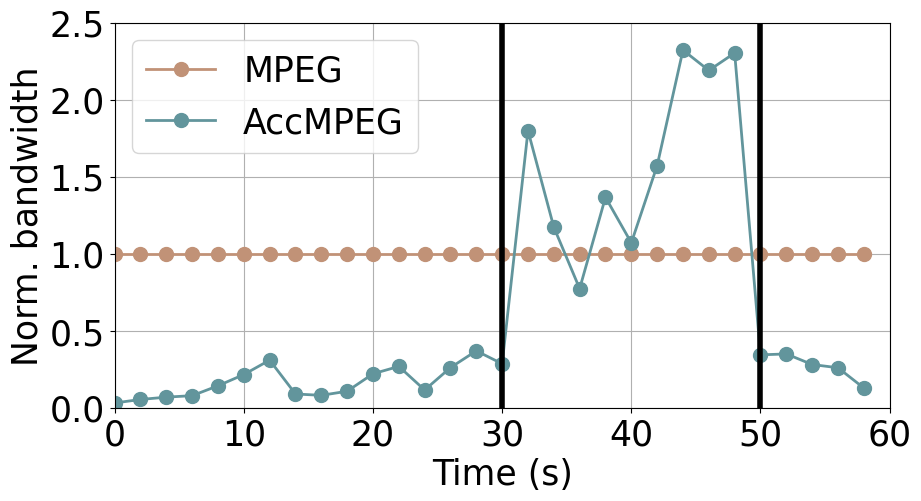

In [100]:

import matplotlib.pyplot as plt
import yaml
with open('stats_adapt_drive', 'r') as f:
    data_full = yaml.load(f.read())

# accmpeg = [filter(['adapt/drive_%d_blackgen_bound_0.3' % i]) for i in range(10, 40)]

plt.rcParams['font.size']=25

accmpeg = [filter(['adapt/drive_%d_blackgen_bound_0.3' % i]) for i in range(10, 40)]

mpeg = [filter(['adapt/drive_%d_qp_44' % i]) for i in range(10, 40)]

fig, ax = plt.subplots(figsize=(10, 5))


# ax.plot(range(0, 60, 2), [i['bw'] for i, j in zip(accmpeg, mpeg)], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')

# ax.plot(range(0, 60, 2), [i['bw'] for i in accmpeg2], c=colors[2], markersize=10, marker='o', linewidth=2, label='AccMPEG')

ax.plot([2*i for i in range(len(mpeg))], [1 for i in mpeg], c=colors[0], markersize=10, marker='o', linewidth=2, label='MPEG')

ax.plot([2*i for i in range(len(accmpeg))], [i['bw']/j['bw'] for i,j in zip(accmpeg,mpeg)], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')




ax.set_ylim(0, 2.5)
ax.axvline(30, linewidth=4, c='black')
ax.axvline(50, linewidth=4, c='black')
ax.legend(loc=0)
ax.set_xlim(0, 60)

ax.grid()
ax.set_xlabel('Time (s)')
# ax.set_yticklabels(['0.0','0.0', '1.0', '2.0'])
ax.set_ylabel('Norm. bandwidth')

savefig('figs/const_heat_bw', fig)

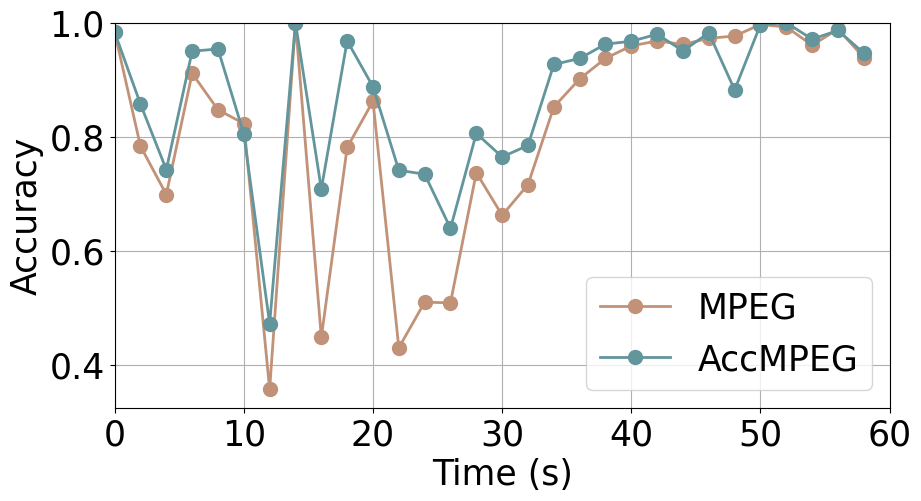

In [101]:

import matplotlib.pyplot as plt
import yaml
with open('stats_adapt_drive', 'r') as f:
    data_full = yaml.load(f.read())

plt.rcParams['font.size']=25

accmpeg = [filter(['adapt/drive_%d_blackgen_cbr_perc_90' % i]) for i in range(10, 16)] + [filter(['adapt/drive_%d_blackgen_cbr_perc_97' % i]) for i in range(16, 26)] + [filter(['adapt/drive_%d_blackgen_cbr_perc_90' % i]) for i in range(26, 40)]

mpeg = [filter(['adapt/drive_%d_cbr_2' % i]) for i in range(10, 16)] + [filter(['adapt/drive_%d_cbr_1' % i]) for i in range(16, 26)] + [filter(['adapt/drive_%d_cbr_2' % i]) for i in range(26, 40)]

fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(range(0, 60, 2), [i['f1'] for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')

ax.plot(range(0, 60, 2), [i['f1'] for i in mpeg], c=colors[0], markersize=10, marker='o', linewidth=2, label='MPEG')

ax.plot(range(0, 60, 2), [i['f1'] for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')


# ax.axvline(30, linewidth=4, c='black')
# ax.axvline(50, linewidth=4, c='black')
ax.legend(loc=0)

ax.set_ylim(top=1)
ax.set_xlim(0, 60)


ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')

savefig('figs/bw_adapt_acc', fig)

[577348, 577340, 577336, 577326, 577392, 589046, 277345, 339185, 330349, 277399, 279899, 277316, 277338, 277382, 277310, 277387, 577413, 577919, 577418, 577422, 578029, 577403, 577423, 577415, 577418, 589019, 577326, 577363, 577257, 577789]


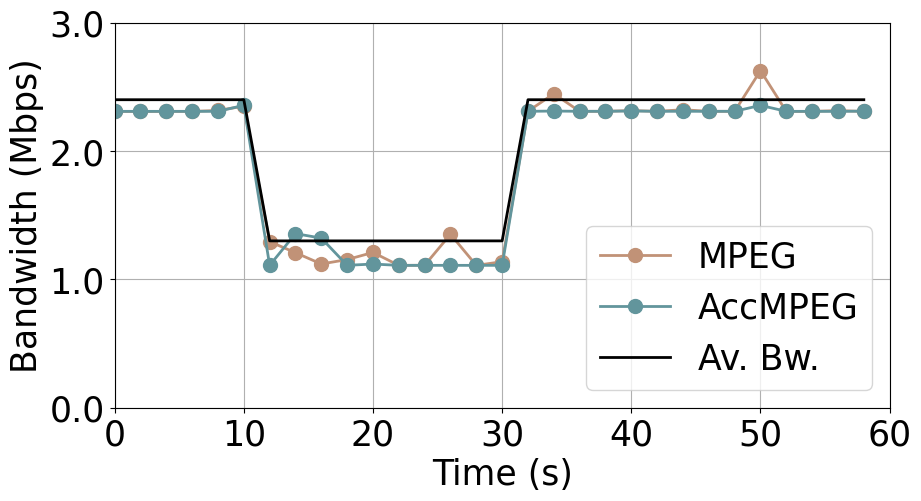

In [102]:

import matplotlib.pyplot as plt
import yaml
with open('stats_adapt_drive', 'r') as f:
    data_full = yaml.load(f.read())

plt.rcParams['font.size']=25

accmpeg = [filter(['adapt/drive_%d_blackgen_cbr_perc_90' % i]) for i in range(10, 16)] + [filter(['adapt/drive_%d_blackgen_cbr_perc_97' % i]) for i in range(16, 26)] + [filter(['adapt/drive_%d_blackgen_cbr_perc_90' % i]) for i in range(26, 40)]

mpeg = [filter(['adapt/drive_%d_cbr_2' % i]) for i in range(10, 16)] + [filter(['adapt/drive_%d_cbr_1' % i]) for i in range(16, 26)] + [filter(['adapt/drive_%d_cbr_2' % i]) for i in range(26, 40)]

fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(range(0, 60, 2), [i['f1'] for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')



ax.plot(range(0, 60, 2), [i['bw'] * 4 / 1000000 for i in mpeg], c=colors[0], markersize=10, marker='o', linewidth=2, label='MPEG')

print([i['bw'] for i in accmpeg])

ax.plot(range(0, 60, 2), [i['bw'] * 4 / 1000000 for i in accmpeg], c=colors[1], markersize=10, marker='o', linewidth=2, label='AccMPEG')

ax.plot(range(0, 60, 2), [2.4]*6 + [1.3]*10+[2.4]*14, c='black', linestyle='-', linewidth=2, label='Av. Bw.')



# ax.axvline(30, linewidth=4, c='black')
# ax.axvline(50, linewidth=4, c='black')
ax.legend(loc=0)

ax.set_ylim(0, 3)
ax.set_xlim(0, 60)
ax.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])

ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Bandwidth (Mbps)')

savefig('figs/bw_adapt_bw', fig)